In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 150

In [2]:
header = ['Datetime','Power']
df = pd.read_csv('channel_1.dat', sep=' ',names=header, skipinitialspace=True)
df.head()


,Datetime,Power
0,1352500095,599
1,1352500101,582
2,1352500107,600
3,1352500113,586
4,1352500120,596


In [3]:
df["Datetime"] = pd.to_datetime(df['Datetime'], unit='s')

df.head()

,Datetime,Power
0,2012-11-09 22:28:15,599
1,2012-11-09 22:28:21,582
2,2012-11-09 22:28:27,600
3,2012-11-09 22:28:33,586
4,2012-11-09 22:28:40,596


In [4]:
df.set_index("Datetime",inplace=True)
df.head()

,Power
Datetime,
2012-11-09 22:28:15,599
2012-11-09 22:28:21,582
2012-11-09 22:28:27,600
2012-11-09 22:28:33,586
2012-11-09 22:28:40,596


# Daily Resample

In [5]:

df_H=df[['Power']].resample('D').mean()
df_H

,Power
Datetime,
2012-11-09,453.682620
2012-11-10,442.936934
2012-11-11,382.709539
2012-11-12,405.616459
2012-11-13,377.907964
...,...
2017-04-22,530.167262
2017-04-23,503.753284
2017-04-24,491.368122


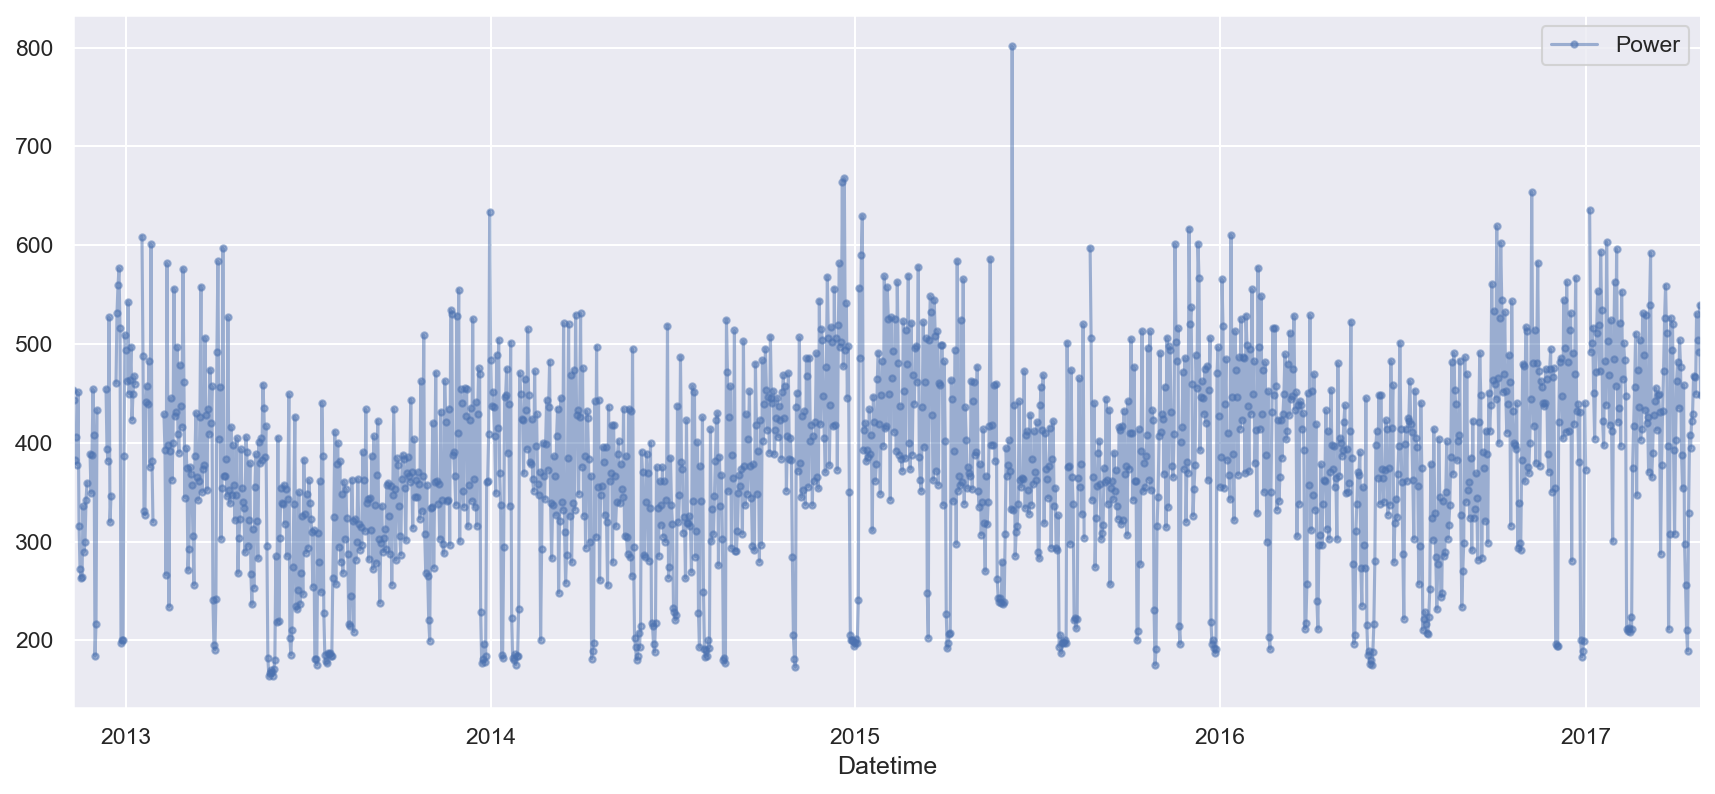

In [6]:
axes =df_H.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Checks for null values and resolves them

In [7]:
data=df_H
# Check for null values in the data
null_values = data.isnull().sum()
print(null_values)

# Drop rows with null values
data = data.dropna()

# Verify if null values have been successfully dropped
null_values_after_drop = data.isnull().sum()
print(null_values_after_drop)

Power    38
dtype: int64
Power    0
dtype: int64


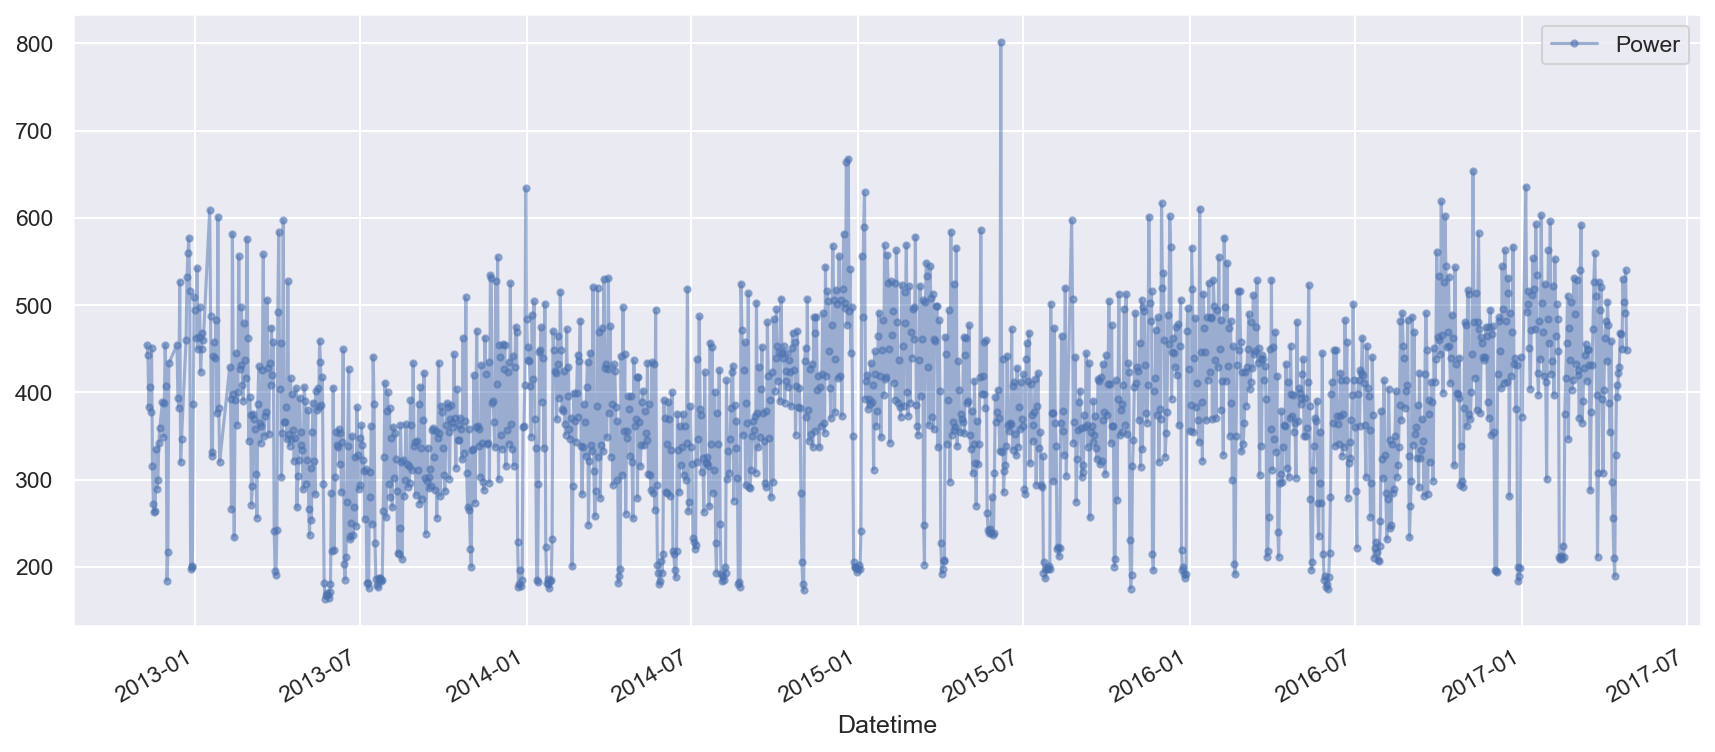

In [8]:
axes =data.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Outliers

In [9]:
from scipy import stats

# Calculate the z-scores of the data
z_scores = stats.zscore(data)

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 5

# Find the indices of the outliers
outlier_indices = (np.abs(z_scores) > threshold).any(axis=1)

In [10]:

# Remove the outliers from the data
data_without_outliers = data[~outlier_indices]

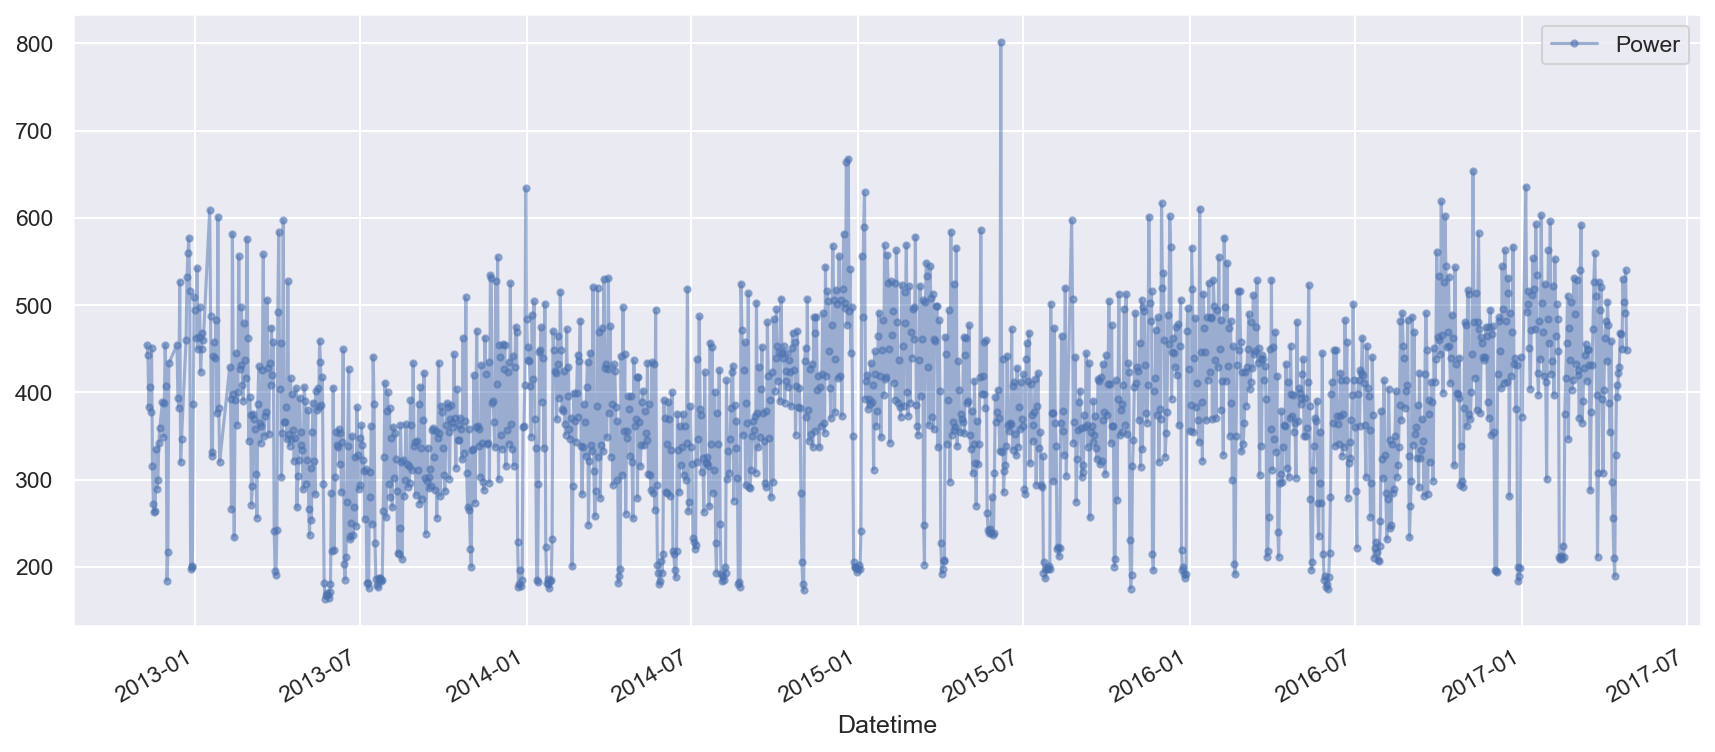

In [11]:
axes =data_without_outliers.plot(marker='.', alpha=0.5,
linestyle='-',figsize=(14, 6), subplots=True)

# Testing for stationary

In [12]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
dfs = data_without_outliers

In [13]:
test_result=adfuller(dfs['Power'])

In [14]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [15]:
adfuller_test(dfs['Power'])

ADF Test Statistic : -6.460969620269115
p-value : 1.4435954589272984e-08
#Lags Used : 14
Number of Observations Used : 1577
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [16]:
## Results show that data is stationary

In [17]:
dfs


,Power
Datetime,
2012-11-09,453.682620
2012-11-10,442.936934
2012-11-11,382.709539
2012-11-12,405.616459
2012-11-13,377.907964
...,...
2017-04-22,530.167262
2017-04-23,503.753284
2017-04-24,491.368122


In [19]:
scaler = MinMaxScaler()

# Extract the "Power" attribute
power_data = dfs['Power'].values.reshape(-1, 1)

# Fit the scaler on the "Power" attribute data
scaler.fit(power_data)

# Normalize the "Power" attribute
normalized_power_data = scaler.transform(power_data)

# Update the DataFrame with the normalized values
dfs['Power'] = normalized_power_data


print(dfs)


               Power
Datetime            
2012-11-09  0.455053
2012-11-10  0.438201
2012-11-11  0.343744
2012-11-12  0.379670
2012-11-13  0.336213
...              ...
2017-04-22  0.575007
2017-04-23  0.533581
2017-04-24  0.514157
2017-04-25  0.589808
2017-04-26  0.446067

[1592 rows x 1 columns]


In [20]:
dfs

,Power
Datetime,
2012-11-09,0.455053
2012-11-10,0.438201
2012-11-11,0.343744
2012-11-12,0.379670
2012-11-13,0.336213
...,...
2017-04-22,0.575007
2017-04-23,0.533581
2017-04-24,0.514157


In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [22]:
#Reviewing: Train / Test Split

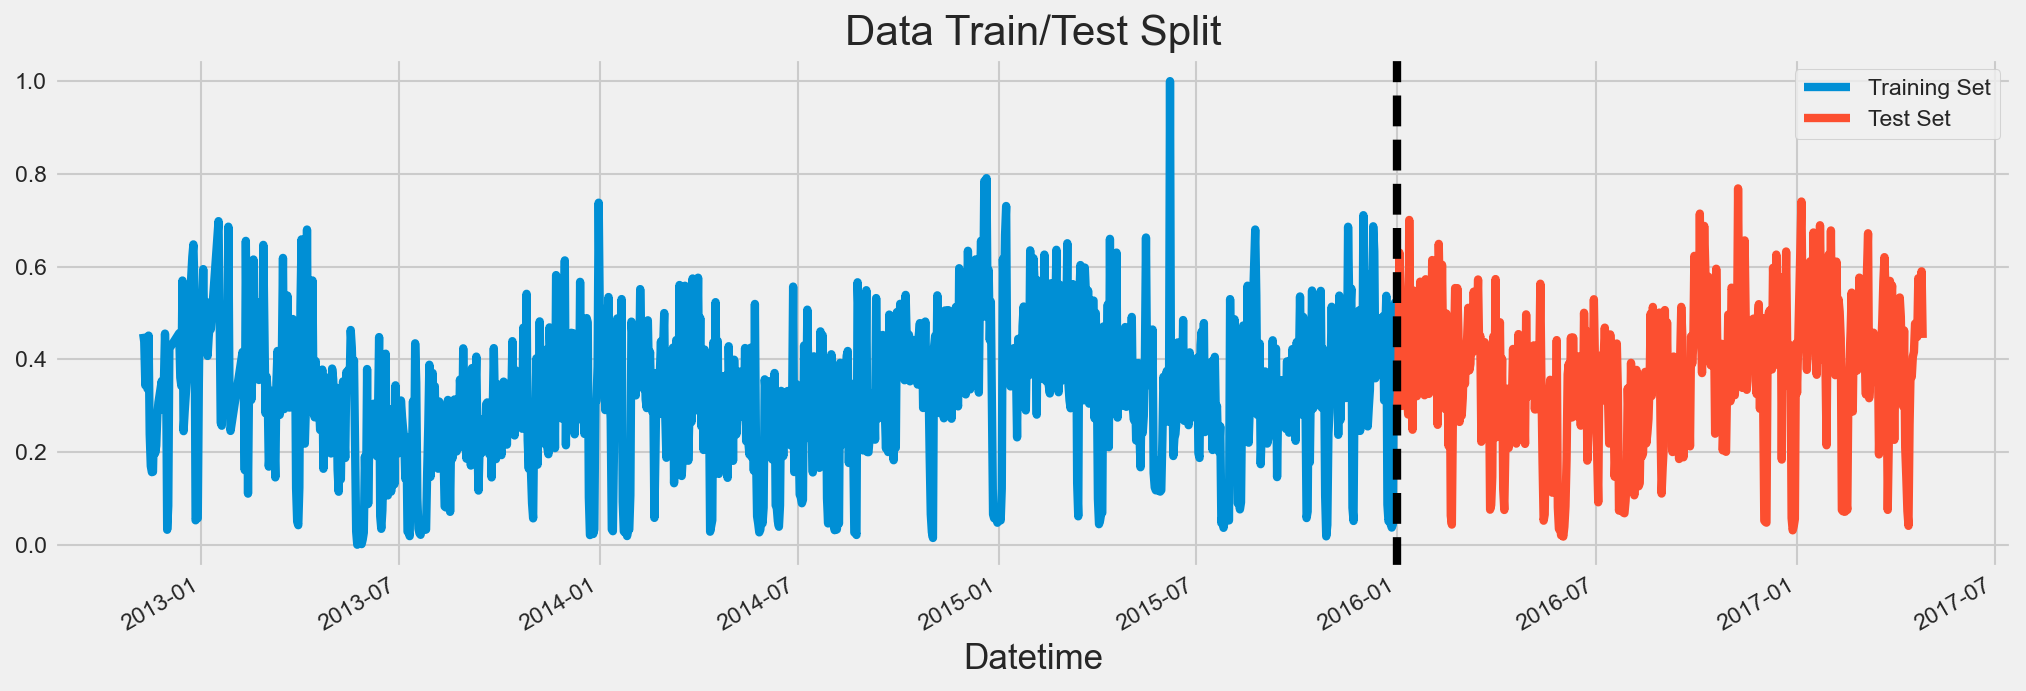

In [23]:
df=dfs
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [24]:
##forecast on test

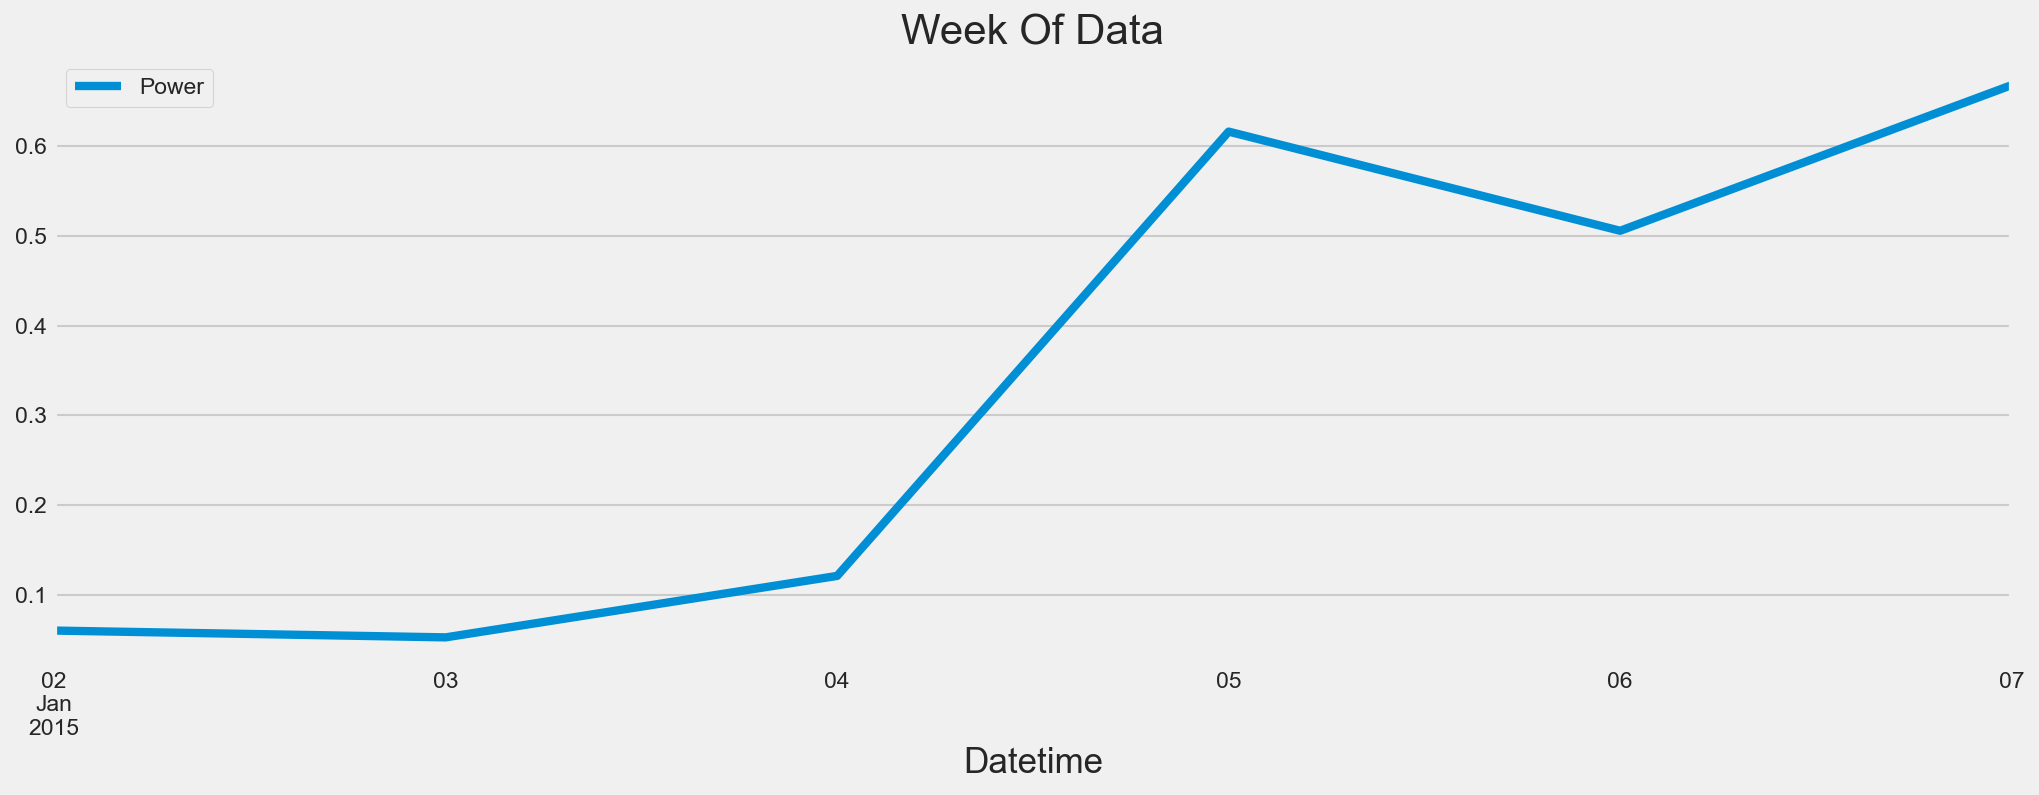

In [25]:
df.loc[(df.index > '01-01-2015') & (df.index < '01-08-2015')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [26]:
##Feature Creation

In [27]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [28]:
##Visualize our Feature / Target Relationship

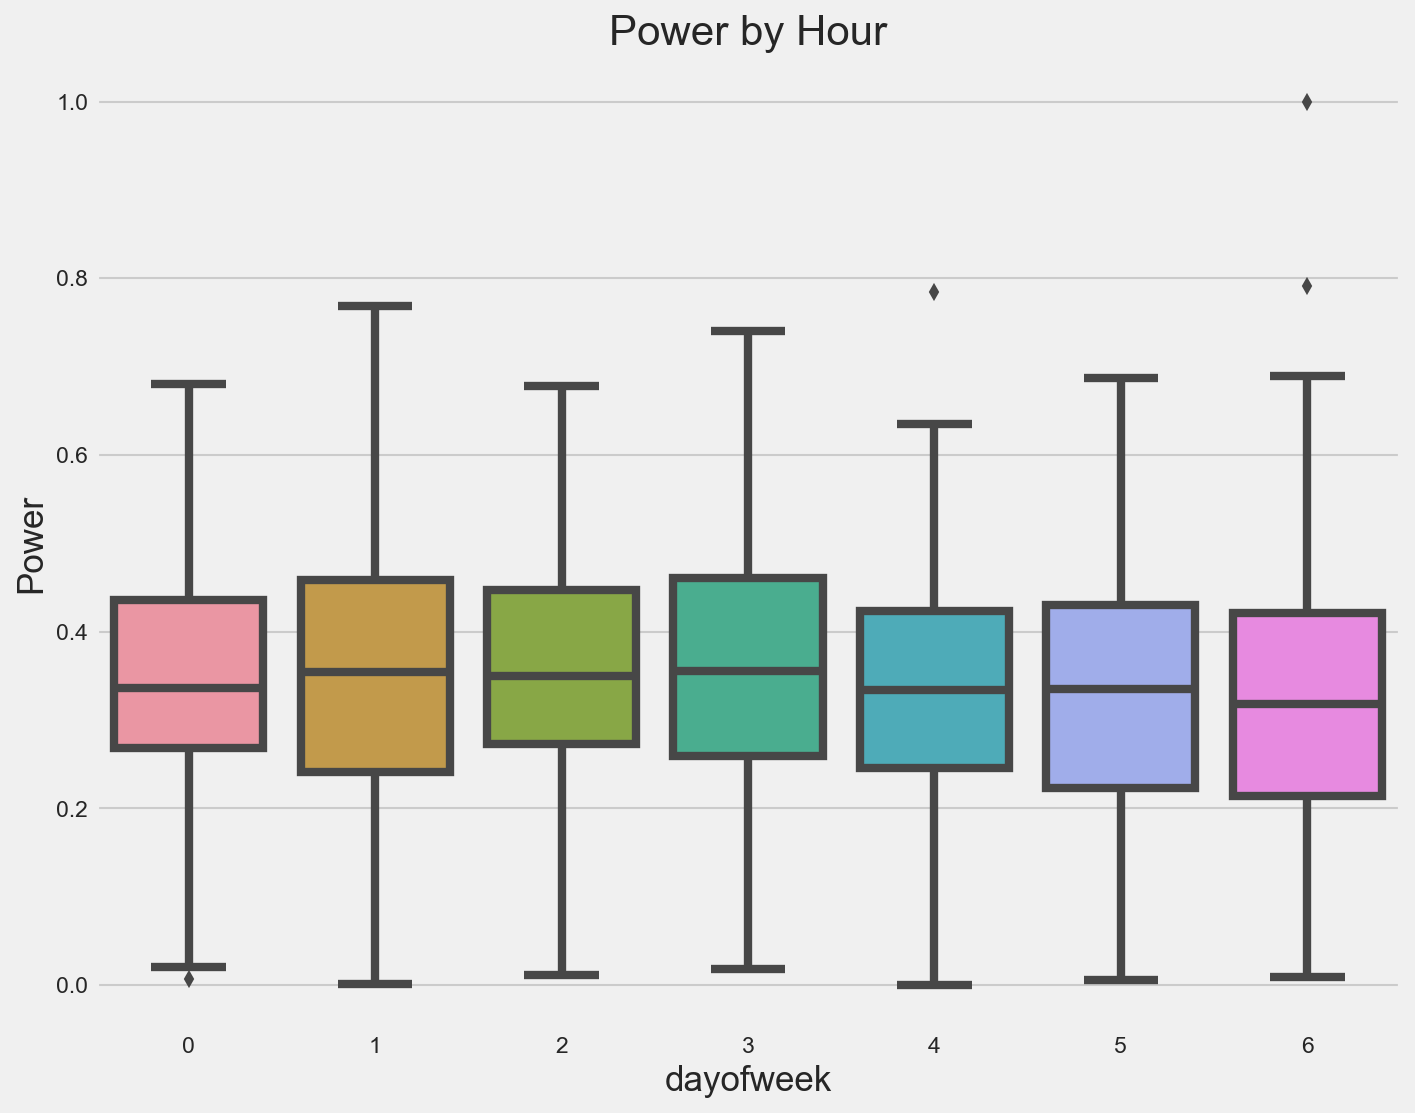

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Power')
ax.set_title('Power by Hour')
plt.show()

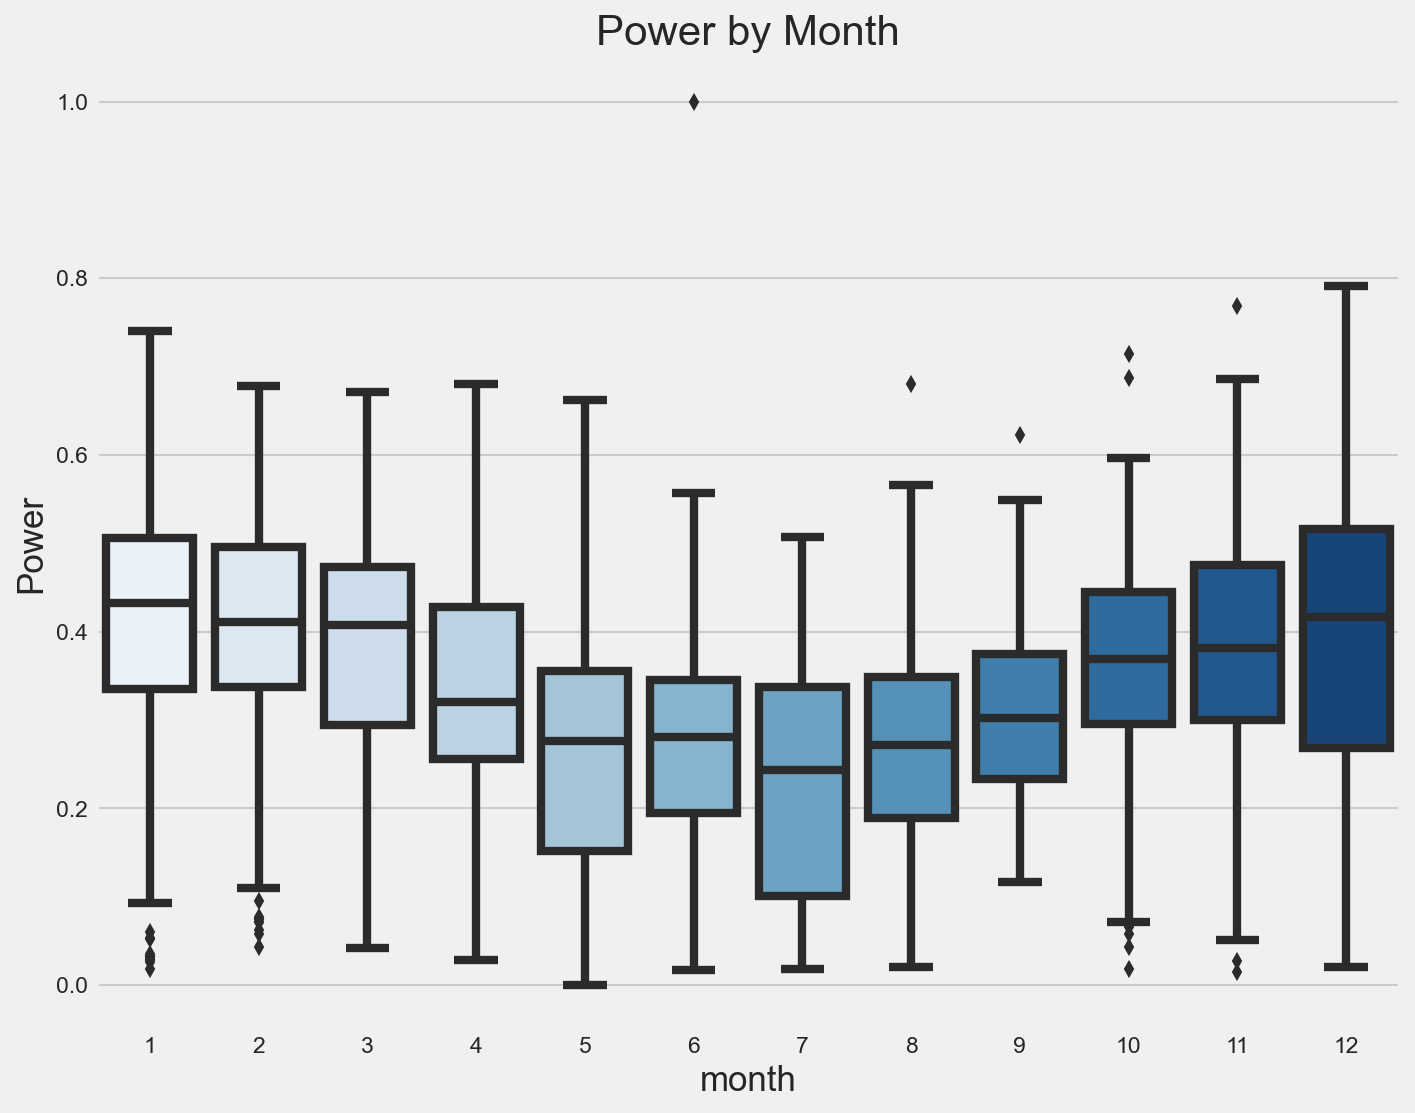

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Power', palette='Blues')
ax.set_title('Power by Month')
plt.show()

In [31]:
##Create Our Model

In [32]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Power'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [33]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.23254	validation_1-rmse:0.19622
[100]	validation_0-rmse:0.15065	validation_1-rmse:0.14472
[200]	validation_0-rmse:0.13167	validation_1-rmse:0.13965
[290]	validation_0-rmse:0.12653	validation_1-rmse:0.13983


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [34]:
##Feature Importance

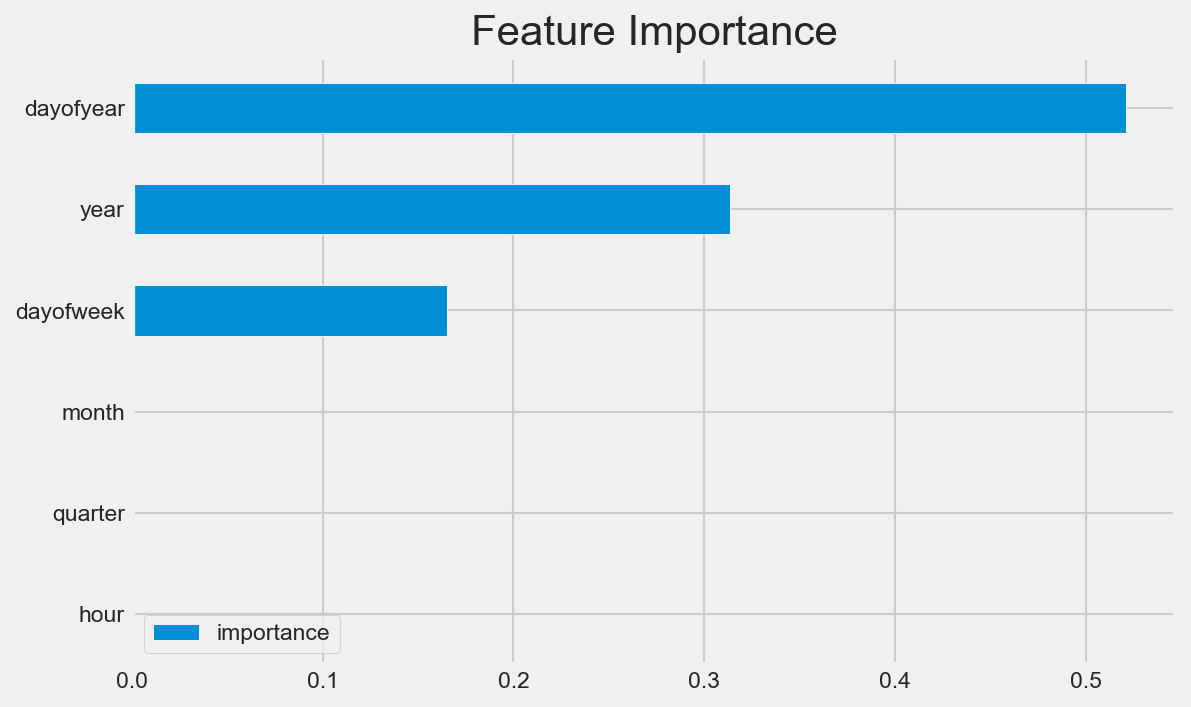

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [36]:
##Forecast On test

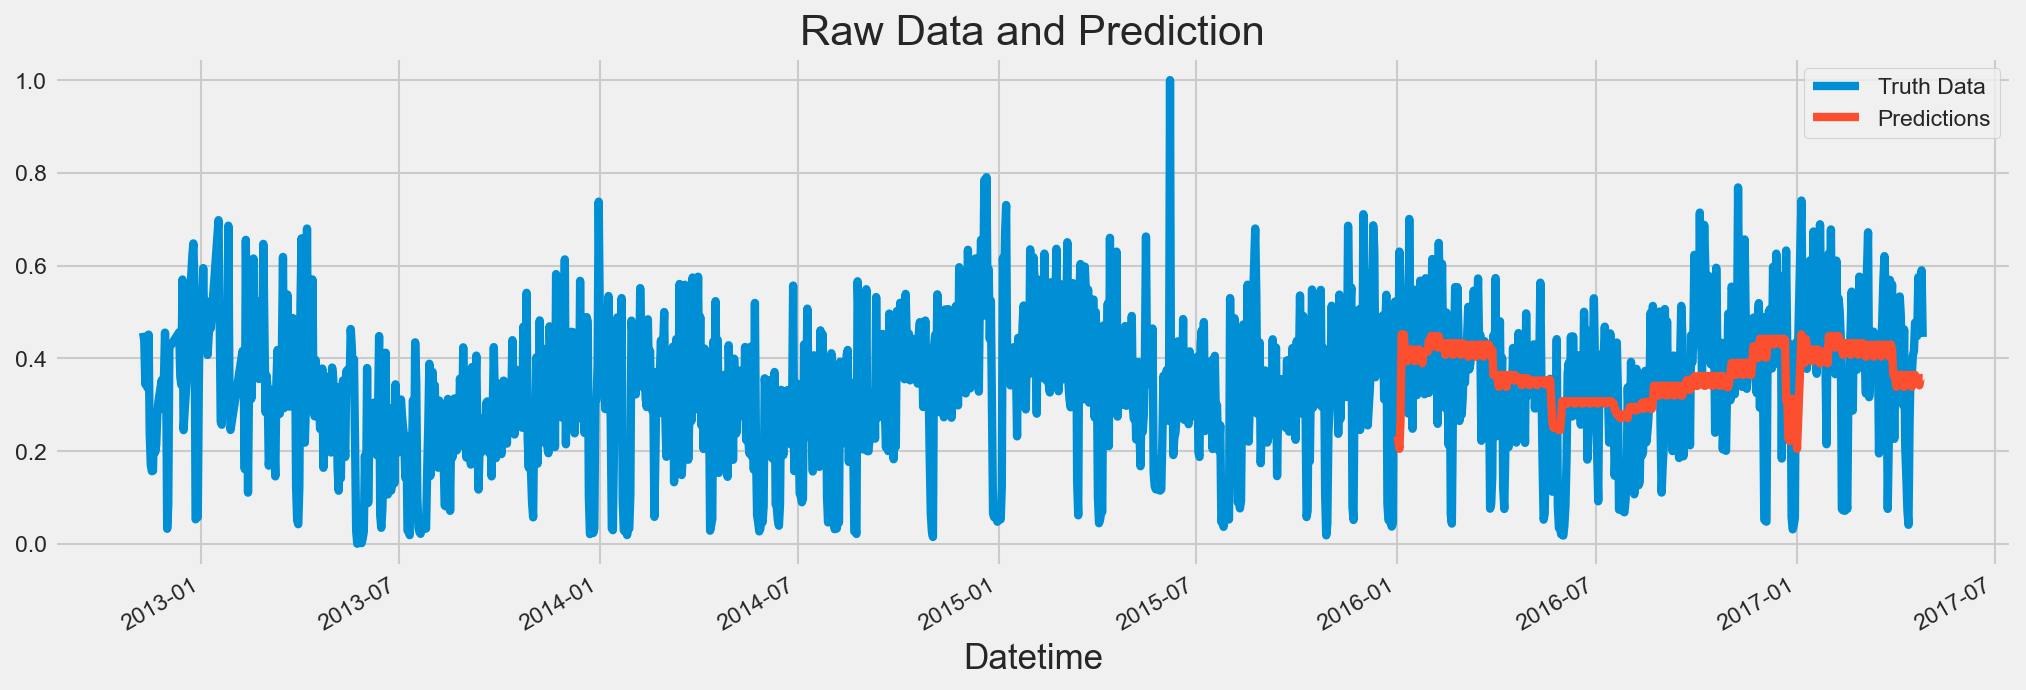

In [37]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Power']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

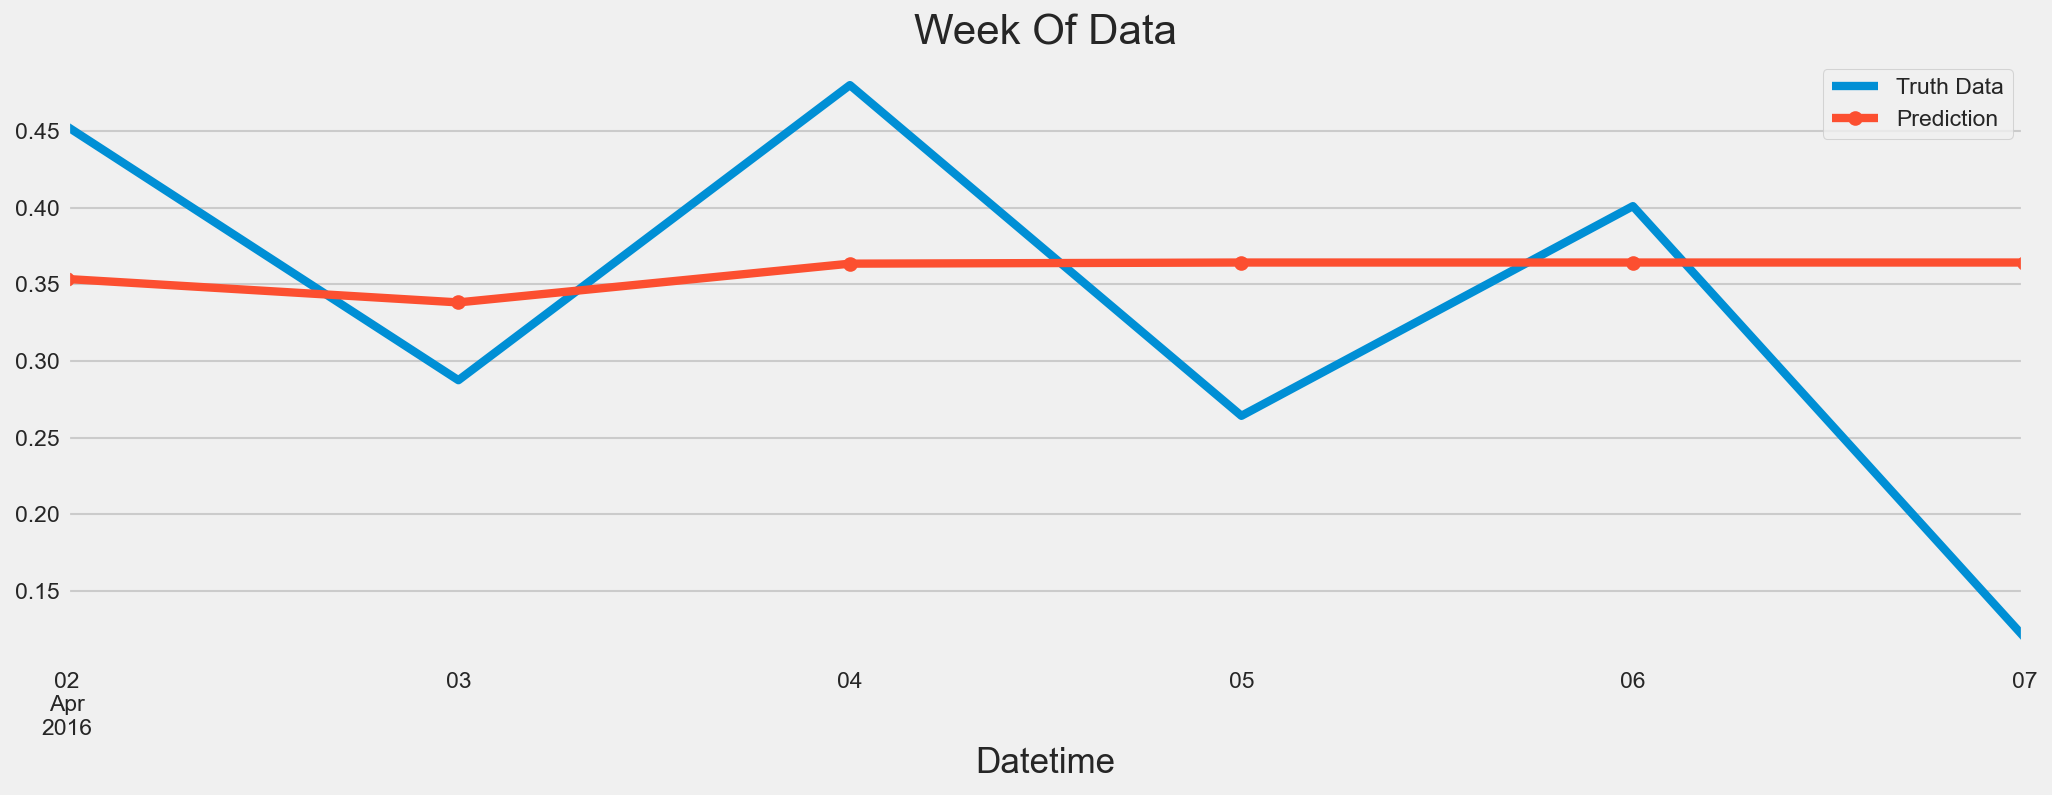

In [38]:
ax = df.loc[(df.index > '04-01-2016') & (df.index < '04-08-2016')]['Power'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2016') & (df.index < '04-08-2016')]['prediction'] \
    .plot(style='-o')
plt.legend(['Truth Data','Prediction'])
plt.show()

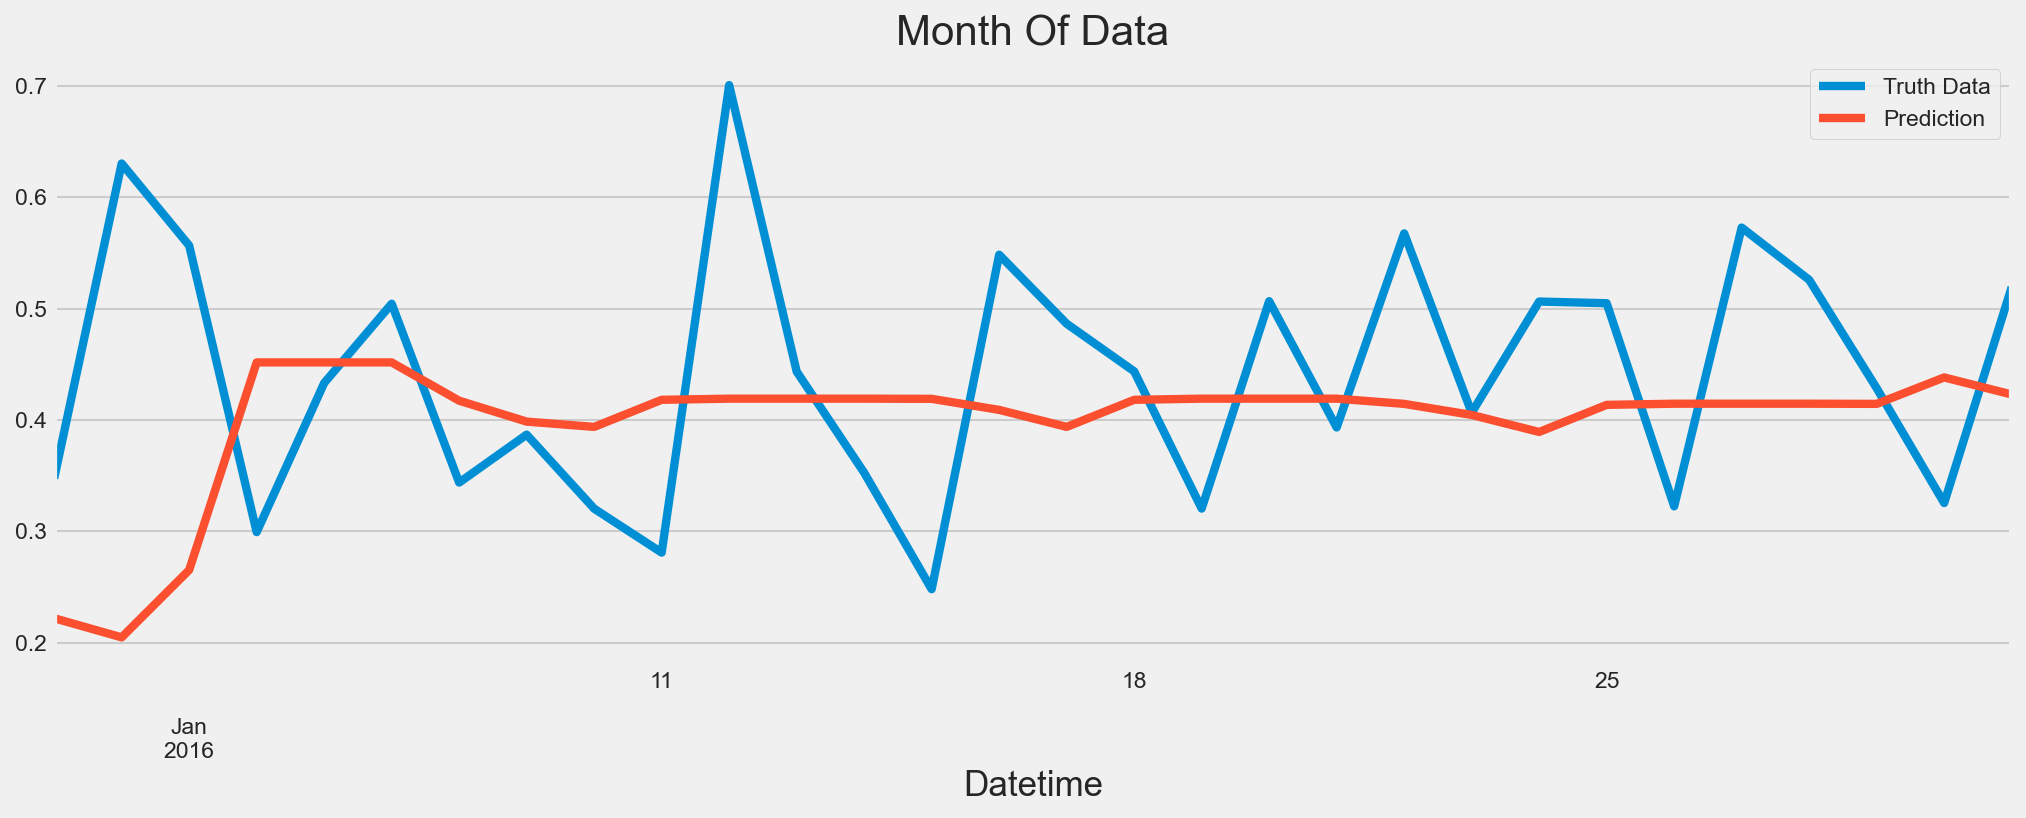

In [39]:
ax = df.loc[(df.index > '01-01-2016') & (df.index < '02-01-2016')]['Power'] \
    .plot(figsize=(15, 5), title='Month Of Data')
df.loc[(df.index > '01-01-2016') & (df.index < '02-01-2016')]['prediction'] \
    .plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [40]:
##Score (RMSE)

In [41]:
score = np.sqrt(mean_squared_error(test['Power'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.14


In [42]:
##Calculate Error

In [43]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-01-03    0.425432
2016-12-02    0.388366
2016-02-20    0.379186
2016-11-08    0.378118
2016-02-19    0.369938
2017-02-14    0.361468
2017-02-16    0.357650
2017-02-13    0.354858
2016-12-04    0.353991
2016-12-03    0.352630
Name: error, dtype: float64

In [44]:
##Function to calculate regression metrics, evaluating accuracy
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    mape = (1- metrics.mean_absolute_percentage_error(y_true, y_pred))


    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))
    print('ok')

In [45]:
regression_results(test['Power'], test['prediction'])

explained_variance:  0.1366
mean_squared_log_error:  0.0111
r2:  0.1364
MAE:  0.1089
MSE:  0.0195
RMSE:  0.1395
MAPE:  0.3176
ok


In [50]:
# Evaluating GridSearch results
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

NameError: name 'grid_search' is not defined

In [51]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()

ValueError: Too many splits=3 for number of samples=1592 with test_size=8760 and gap=24.

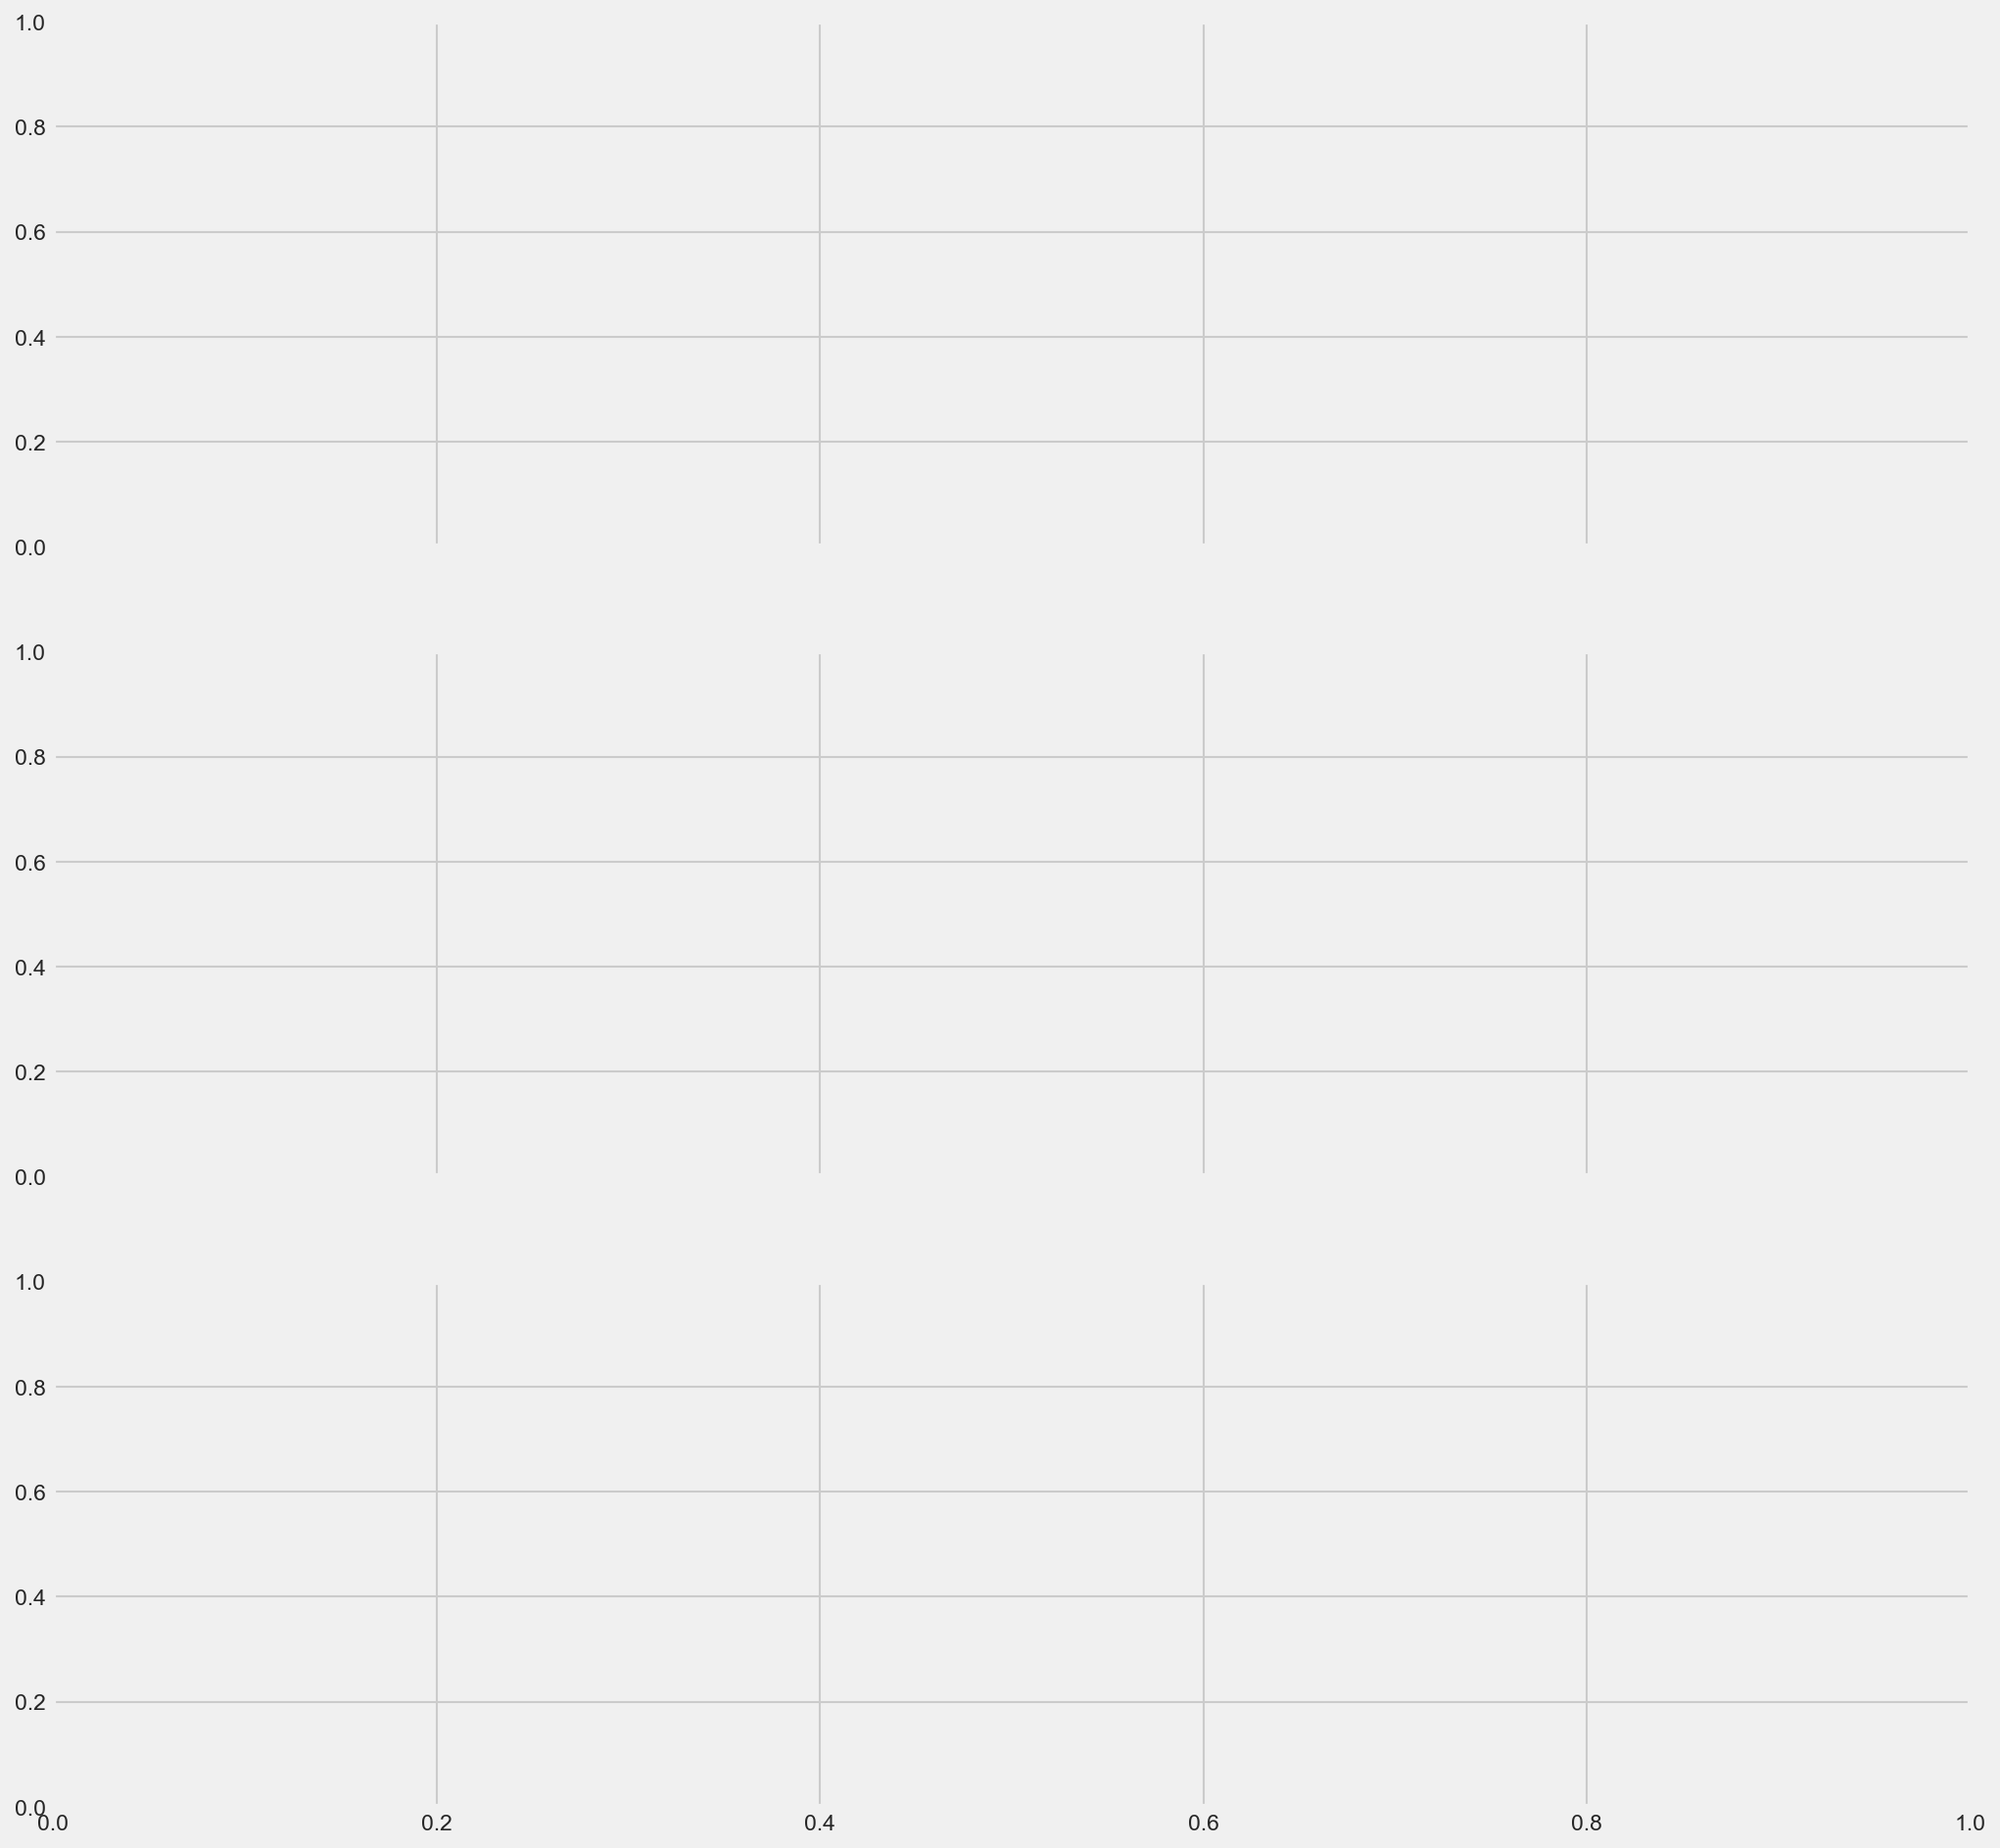

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Power'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Power'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [53]:
#Forecasting Horizon Explained

In [54]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [55]:
#Lag Features

In [56]:
def add_lags(df):
    target_map = df['Power'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [57]:
df = add_lags(df)

In [58]:
#Train Using Cross Validation

In [59]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Power'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

ValueError: Too many splits=3 for number of samples=1592 with test_size=8760 and gap=24.

In [60]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds nan
Fold scores:[]


E:\New folder\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\New folder\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Power'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[18:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.22229
[100]	validation_0-rmse:0.14976
[200]	validation_0-rmse:0.13294
[300]	validation_0-rmse:0.12809
[400]	validation_0-rmse:0.12580
[499]	validation_0-rmse:0.12426


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [62]:
df.index.max()

Timestamp('2017-04-26 00:00:00')

In [63]:
# Create future dataframe
future = pd.date_range('2017-04-26 17:00:00','2018-04-27 17:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [64]:
future_w_features = df_and_future.query('isFuture').copy()

In [65]:
#Predict the future

In [66]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

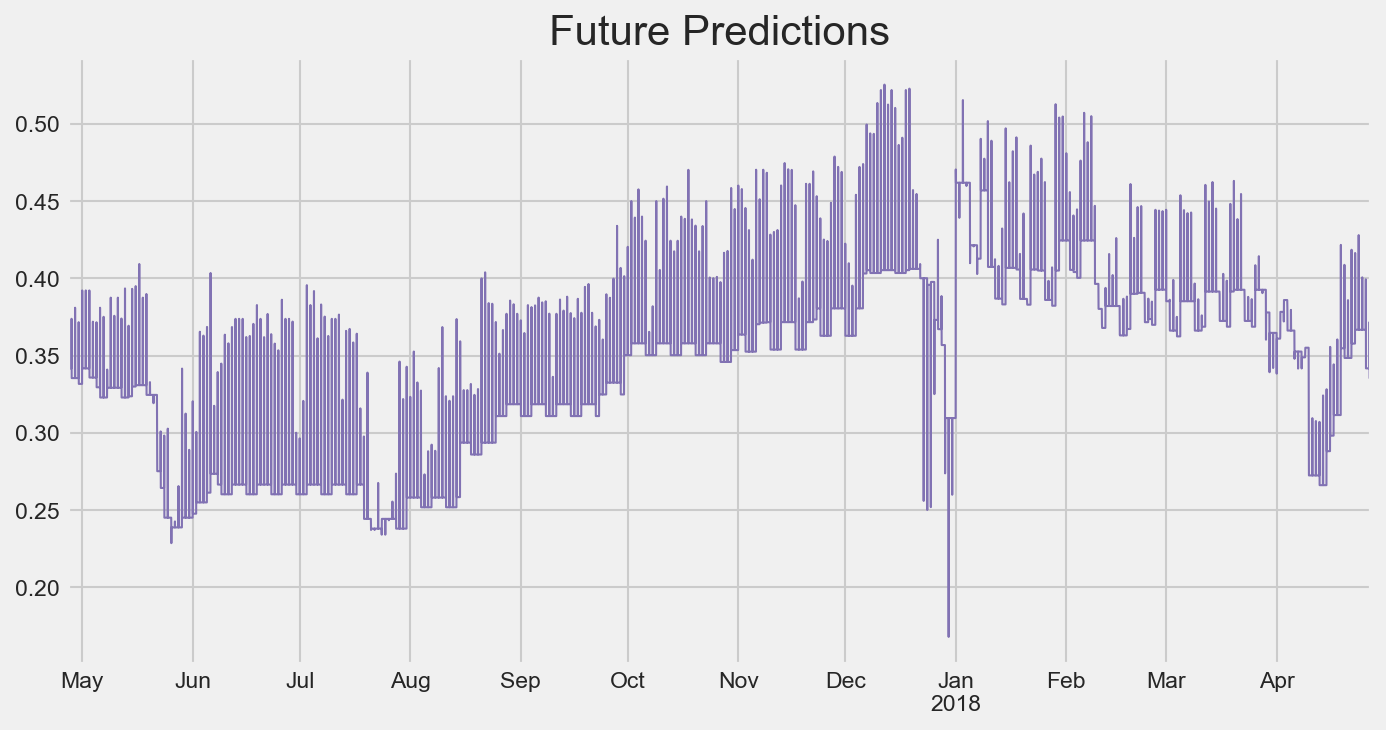

In [67]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [68]:
#Forecast on Test Set

In [ ]:
df.head()